# A Visual Guide to Quantization 

- As their name suggests, Large Language Models (LLMs) are often too large to run on consumer hardware. 
- These models may exceed billions of parameters and generally need GPUs with large amounts of VRAM to speed up inference. 
- As such more and more research has been focused on making these models smaller through improved training, adapters, etc. 
- One major technique in this field is called quantization. 

- 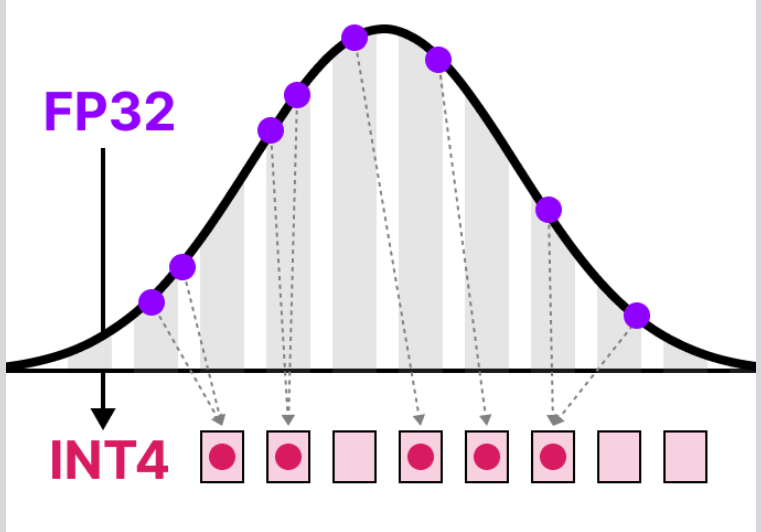

- Given value is often represented as a floating point number: a positive or negative number with a decimal point. 

- 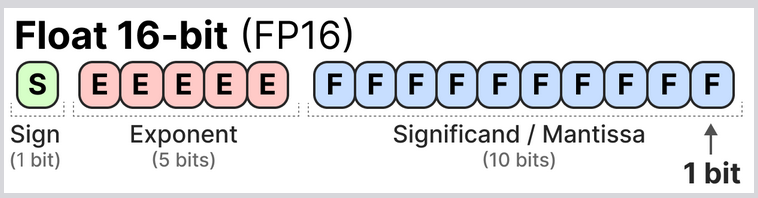

- Together, these three aspects can be used to calculate a value given a certain set of bit values. 
- 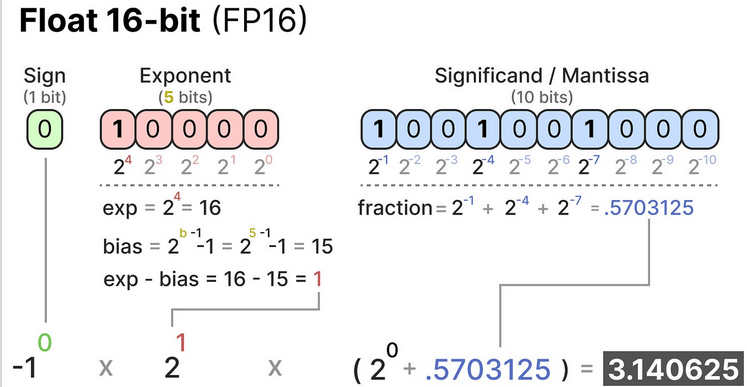

- The more bits we use to represent a value, the more precise it generally is: 
- 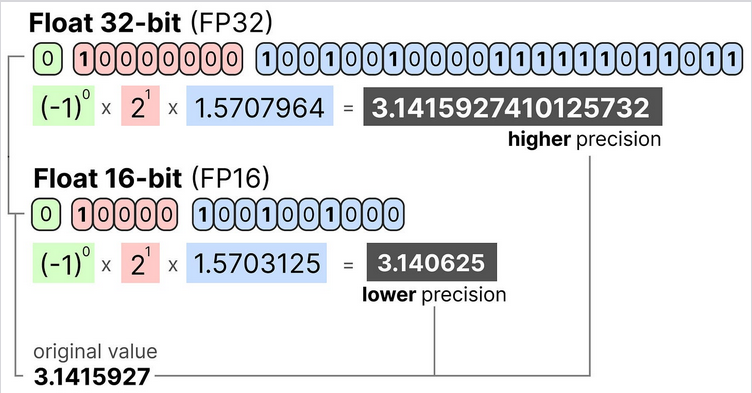

- The interval of representable numbers a given representations can take is called the dynamic range whereas the distance between two neighboring values is called precision. 
- 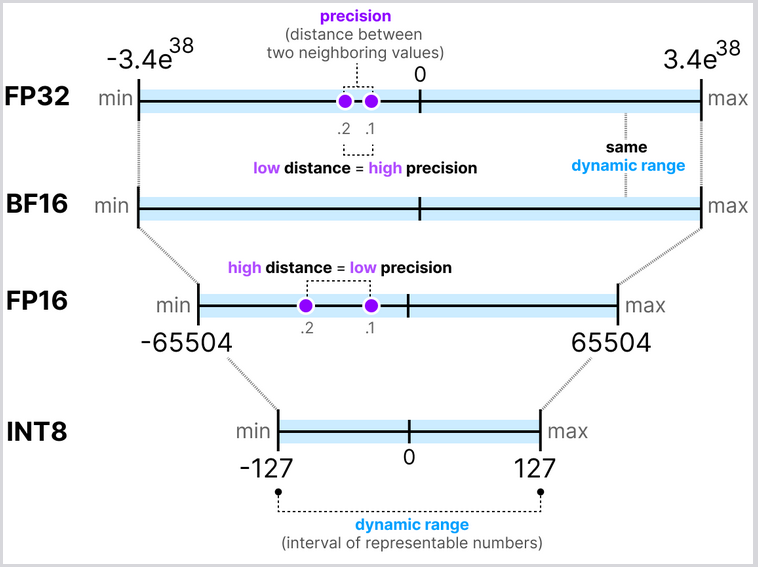

- A nifty feature of these bits is that we can calculate how much memory your device needs to store a given value. 
- Since there are 8 bits in a byte of memory, we can create a basic formula for most forms of floating point representations. 
- 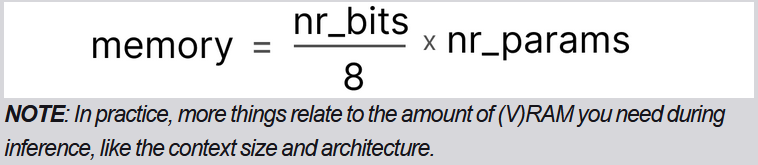
- Now let's assume that we have a model with 70 billion parameters. 
- Most models are natively represented with float 32-bit (often called full-precision), which would require 280 GB of memory just to load the model. 
- 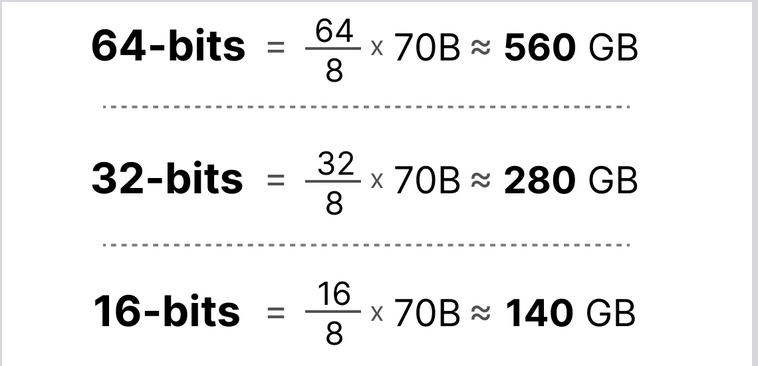

- As the precision decreases the accuracy of the models generally does as well. 
- We want to reduce the number of bits representing values while maintaining accuracy.. This is where quantization comes in! 
- Quantization aims to reduce the precision of a model's parameter from higher bit-widths (like 32-bit floating point) to lower bit-widths (like 8-bit integers.)
- 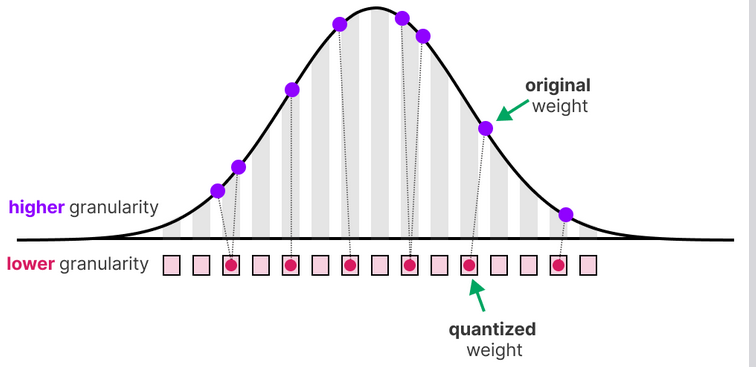

- The main goal of quantization is to reduce the number of bits (colors) needed to represent the original parameters while preserving the precision of the original parameters as best as possible. 

- For each reductions in bits, a mapping is performed to "squeeze" the initial FP32 representations into lower bits. 
- In practice, we do not need to map the entire FP32 range into INT8. 
- We merely need to find a way to map the range of our data (the model's parameters) into INT8. 
- Common squeezing/mapping methods are symmetric and asymmetric quantization and are forms of linear mapping. 

- In symmetric quantization, the range of the original floating-point values is mapped to a symmetric range around zero in the quantized space. 
- A nice example of a form of symmetric quantization is called absolute maximum (absmax) quantization. 

- Asymmetric quantization, in contrast, is not symmetric around zero. 
- Instead, it maps the minimum and maximum values from the float range to the minimum and maximum values of the quantized range. 
- The method we are going to explore is called zero-point quantization. 

- 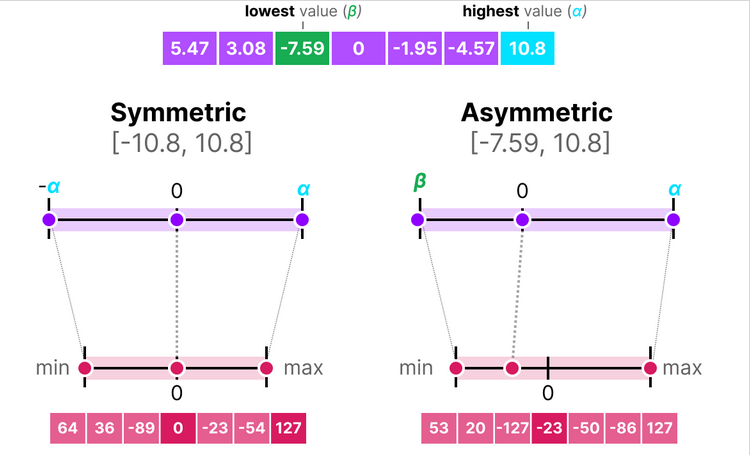

- The major advantage is that the quantization error of the non-outliers is reduced significantly. However, the quantization error of outliers increases. 
- In the example, i showed a naive method of choosing an arbitrary range of [-5, 5]. The process of selecting this range is known as calibration which aims to find a range that includes as many values as possible while minimizing the quantization error. 
- We can view the weights and biases of an LLM as static values since they are known before running the model. For instance, the 20GB file of Llama 3 consist of mostly of its weights and biases. 
- Since there are significantly fewer biases (millions) than weights (billions), the biases are often kept in higher precision, and the main effort of quantization is put towards the weights. 
- For weights, which are static and known, calibration techniques for choosing the range include: 
    - Manually chosing a percentile of the input range. 
    - Optimize the mean squared error (MSE) between the original and quantized weights. 
    - Minimizing entropy (KL-divergence) between the original and quantized values. 

- The input that is continuosly updated throuhout the LLM is typically referred to as "activations". 
- Unlike weight, activations vary with each input data fed into the model during inference, making it challenging to qunatize them accurately. 
- Broadly, there are two methods for calibrating the quantization method of the weights and activations: 
    - Post-Training Quantization (PTQ)
        - Quantization after training 
    - Quantization Aware Training (QAT)
        - Quantization during training/fine-tuning 

- There are two forms of quantization of the activations:
    - Dynamic Quantization
    - Static Quantization 
- zeropoint (z)
- scale factor (s)
- In general, dynamic quantization tends to be a bit more accurate since it only attempts to calculate the s and z values per hidden layer. However, it might increase compute time as these values need to be calculated. 
- In contrast, static quantization is less accurate but is faster as it already knows the s and z values used for quantization. 

- Going below 8-bit quantization has proved to be a difficult task as the quantization error increases with each loss of bit. 
- Fortunately, there are several smart ways to reduce the bits to 6, 4, and even 2-bits. 
- We will explore two methods that are commonly shared on HuggingFace: 
    - GPTQ (full model on GPU)
    - GGUF (potentially offload layers on the CPU)
- GPTQ is arguably one of the most well-known methods used in practice for quantization to 4-bits. 
- It uses asymmetric quantization and does so layer by layer such that each layer is processed independently before continuing to the next. 
- 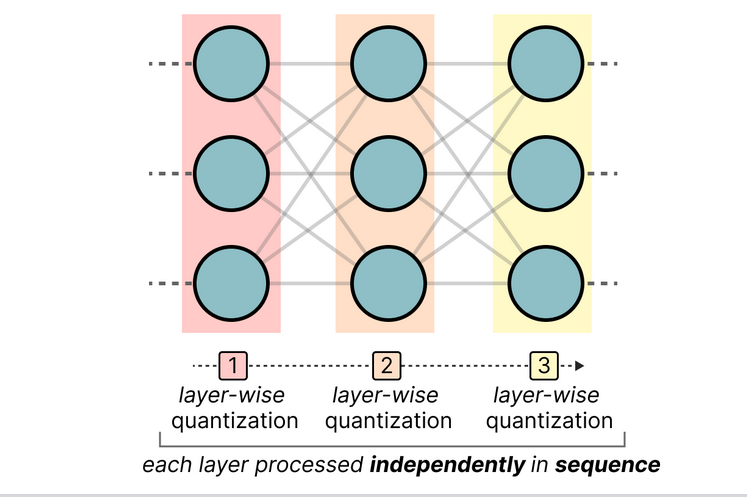
- During this layer-wise quantization process, it first converts the layer's weights into the inverse-Hessian. 
- It is second-order derivative of the model's loss function and tells us how sensitive the model's output is to changes in each weight. 
- Simplified, it essentially demonstrates the (inverse) importance of each weight in a layer. 
- Weights associated with smaller values in the Hessian matrix are more crucial because small changes in these weights can lead to significant changes in the model's performance. 
- Next, we quantize and then dequantize the weight of the first row in our weight matrix:
    - This process allows us to calculate the quantization error (q) which we can weigh using the inverse-Hessian (h_1) that we calculated beforehand. 
    - Next, we redistribute this weighted quantization error over the other weights in the row. This allows for maintaining the overall function and output of the network. 
    - We iterate over this process of redistributing the weighted quantization error until all values are quantized. 
    - This works so well because weights are typically realted to one another. 
    - So when one weight has a quantization error, related weights are updated accordingly (through the inverse-Hessian). 

### GGUF
- While GPTQ is a great quantization method to run our full LLM on a GPU, we might not always have that capacity. 
- Instead, we can use GGUF to offload any layer of the LLM to the CPU. 
- This allows us to use both the CPU and GPU when we do not have enough VRAM. 
- The quantization method GGUF is updated frequently and might depend on the level of bit quantization. 
- Use the super and sub block. 

### Quantization Aware Training
- We saw how we could quantize a model after training. A downside to this approach is that this quantization does not consider the actual training process. 
- This is where Quantization Aware Training (QAT) comes in. 
- Instead of quantizing a model after it was trained with post-training quantization (PTQ), QAT aims to learn the quantization procedure during training. 
- QAT tends to be more accurate than PTQ since the quantization was already considered during training. It work as follows: 
    - During training, so-called "fake" quants are introduced. This is the process of first quantizing the weights to, for example, INT4 and then dequantizing back to FP32: 
    - This process allows the model to consider the quantization process during training, the calculation of loss, and weight updates. 
    - QAT attempts to explore the loss landscape for "wide" minima to minimize the quantization errors as "narrow" minima tend to result in larger quantization errors.  